# The Impact of Private Equity on Hospital Bed Availability


## Introdction
In recent years, private equity firms have assumed control of numerous hospitals across the United States. These takeovers have significantly influenced the total number of beds reported by healthcare providers. Understanding the implications of this shift is crucial, especially considering that the availability of hospital beds directly affects patient outcomes.

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings
import pylab as py
import scikit_posthocs as sp
from sklearn.model_selection import cross_val_score


## read data

In [2]:
df = pd.read_csv("PE Hospital Tracker.csv",index_col = 0)

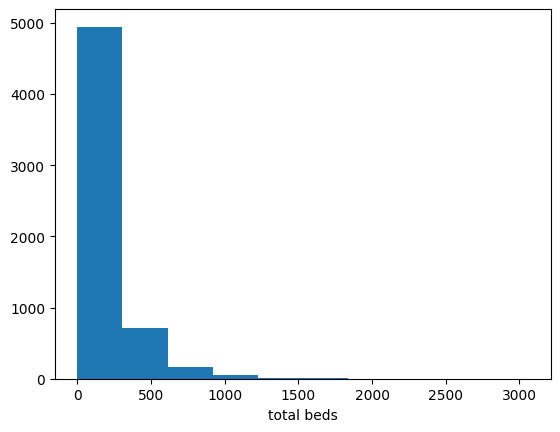

In [3]:
plt.hist(df['POS Total Beds'])
plt.xlabel('total beds')
plt.show()

## Normality test

In [4]:
stat, p = stats.shapiro(df['POS Total Beds'].dropna())
print("Shapiro's wilks test Statistics=%.3f, p=%.3f" % (stat, p))

# Interpret the result
alpha = 0.05
if p > alpha:
    print('Sample is normal')
else:
    print('Sample is non-normal')

Shapiro's wilks test Statistics=0.673, p=0.000
Sample is non-normal


## Q-Q plots transformation

In [5]:
xi = np.array(df['POS Total Beds'].dropna().sort_values())
data_quantile= np.arange(0,len(xi))
prob_lvl = (data_quantile-1/3)/(len(data_quantile)+1/3)
qi = stats.norm.ppf(prob_lvl)



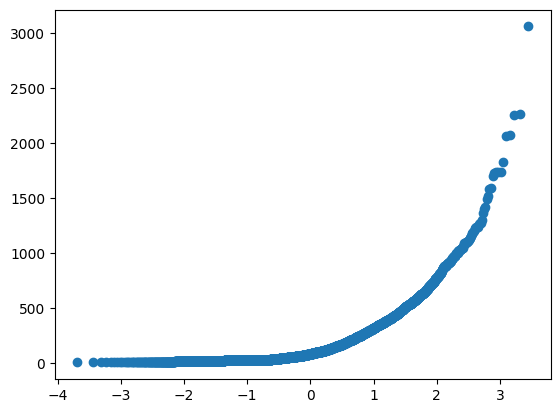

In [6]:
plt.scatter(qi, xi)
plt.show()

### Tukey Transformations

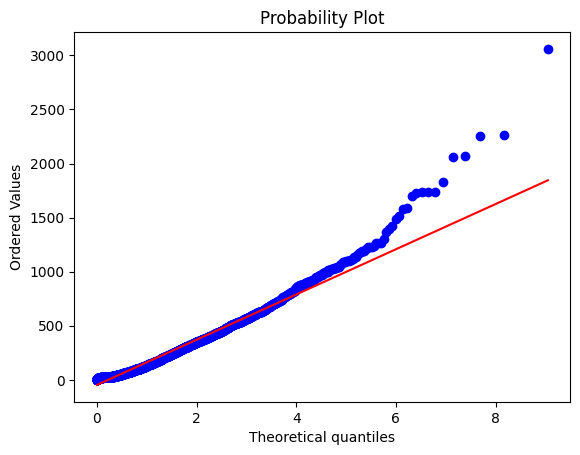

In [7]:
measurements = np.array(df['POS Total Beds'].dropna())
stats.probplot(measurements, dist="expon", plot=plt)
plt.show()

### Brown-Forsythe robust against outliers 
#### constant variance test

In [8]:
df_group1 = df.loc[df["Currently PE?"] == "Y"]
df_group2 = df.loc[df["Currently PE?"] == "N"]
df_group3 = df.loc[df["Currently PE?"] == "VC"]



result = stats.levene(df_group1["POS Total Beds"].dropna(), df_group2["POS Total Beds"].dropna(), df_group3["POS Total Beds"].dropna(), center='median')
print("Brown-forsythe:")
print("Test statistic:", result.statistic)
print("p-value:", result.pvalue)
if result.pvalue > .05:
    print("The variances not equal")
else:
    print("At least one variance differs")


Brown-forsythe:
Test statistic: 30.7598853803494
p-value: 5.1322331421214615e-14
At least one variance differs


## Kruskal Wallis Test: Equal variance for when normality is violated or nonequal sample size

In [9]:
test_stats = stats.kruskal(df_group1["POS Total Beds"].dropna(), df_group2["POS Total Beds"].dropna(), df_group3["POS Total Beds"].dropna())
print("Nonparametric KW-test")  

print(f"test statistics: {test_stats[0]}\np-value: {test_stats[1]}\n")

if test_stats[1] > .05:
    print("all median are equal")
else:
    print("at least one median differs")
    
if test_stats[1] > .05:
    print("All distribution are identical")
else:
    print("Not all distribution are identical")

Nonparametric KW-test
test statistics: 28.606771639539307
p-value: 6.139294487178189e-07

at least one median differs
Not all distribution are identical


#### Distribution of each current owned by number of total beds

Number of duplicate rows: 6133


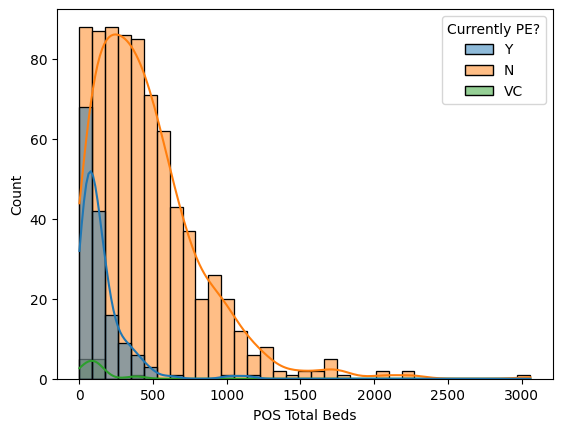

In [10]:

duplicates = df.duplicated(subset=['POS Total Beds', 'Currently PE?'])
print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicate rows
df_cleaned = df.drop_duplicates(subset=['POS Total Beds', 'Currently PE?'])


# Reindex if needed
df_cleaned.reset_index(drop=True, inplace=True)


# Now you can use df_cleaned for your sns.histplot
sns.histplot(x='POS Total Beds',kde=True, hue='Currently PE?', data=df_cleaned)
plt.show()


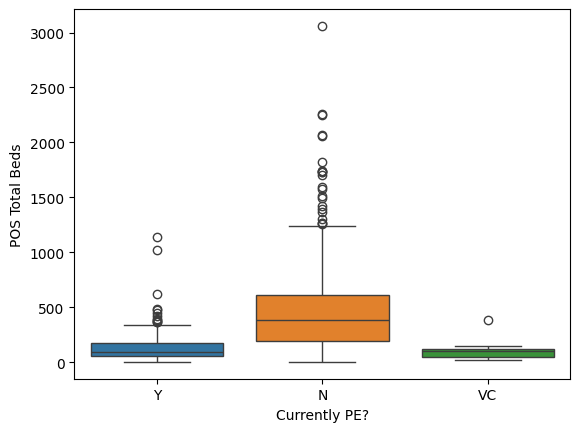

In [11]:
sns.boxplot(y='POS Total Beds', x='Currently PE?',hue = 'Currently PE?', data=df_cleaned)
plt.show()


#### Proportion of hospital who are and who are not PE owned

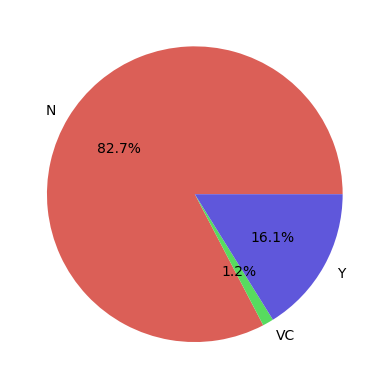

In [12]:

# Define labels and sizes for the slices
labels = df_cleaned.groupby(df_cleaned['Currently PE?']).size().index
sizes = df_cleaned.groupby(df_cleaned['Currently PE?']).size()

#
colors = sns.color_palette("hls", 3)

# Create a pie chart

plt.pie(sizes, labels =labels, colors = colors, autopct='%1.1f%%')

# Display the chart
plt.show()


### Test difference in mean for nonparametric data

In [13]:
data = [df_cleaned[df_cleaned["Currently PE?"] == "Y"]["POS Total Beds"],
        df_cleaned[df_cleaned["Currently PE?"] == "N"]["POS Total Beds"],
        df_cleaned[df_cleaned["Currently PE?"] == "VC"]["POS Total Beds"]]
p_values = np.array(sp.posthoc_dunn(data, p_adjust='bonferroni'))
print(f"Dunn's test \np_values:\n{p_values}\n")
for i in range(len(p_values)):
    for j in range(len(p_values)):
        if p_values[i,j]<0.05:
            print(f"Group {i+1} is significantly different from Group {j+1}")

Dunn's test 
p_values:
[[1.00000000e+00 1.49489276e-33 1.00000000e+00]
 [1.49489276e-33 1.00000000e+00 1.27044041e-04]
 [1.00000000e+00 1.27044041e-04 1.00000000e+00]]

Group 1 is significantly different from Group 2
Group 2 is significantly different from Group 1
Group 2 is significantly different from Group 3
Group 3 is significantly different from Group 2


### The independence of the type of hospital ownership over total beds

H0: The hospital ownership is independent of the total beds available

Ha: The hospital ownership depends on the total number beds available


In [14]:
observed =pd.crosstab(df_cleaned['Currently PE?'],  pd.cut(df_cleaned['POS Total Beds'], 
                                                 labels =['lvl_1','lvl_2','lvl_3','lvl_4','lvl_5'], 
                                                 bins =5))
res = stats.chi2_contingency(observed)

In [15]:
print(f'chi_2: {res.statistic:.3f}\np value: {res.pvalue:.3f}')
if res.pvalue < 0.05:
    print(f'the column variable depends on the row variable')
else:
    print(f'the column variable is independent of the row variable')

chi_2: 42.353
p value: 0.000
the column variable depends on the row variable


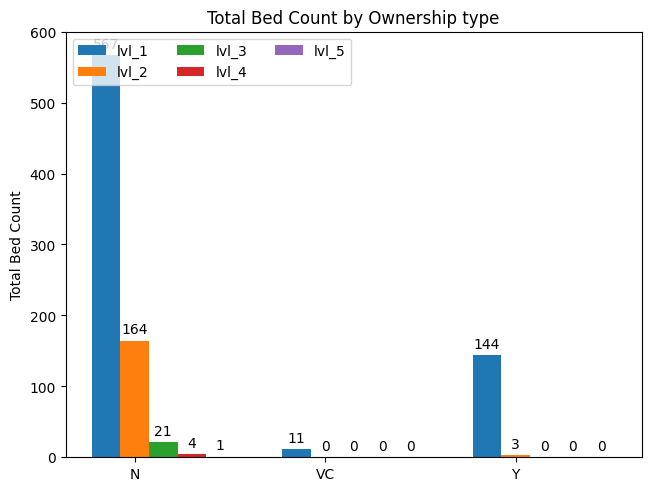

In [16]:
x = np.arange(len(observed.index))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in observed.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Bed Count')
ax.set_title('Total Bed Count by Ownership type')
ax.set_xticks(x + width, observed.index)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 600)

plt.show()

# Regression analysis

In [17]:
print(f"mean = {np.mean(df_cleaned['POS Total Beds'])}\nvariance = {np.var(df_cleaned['POS Total Beds'])}")

mean = 399.78032786885245
variance = 127544.8380829526


## Negative binomial regression

In [18]:
df_cleaned = df_cleaned.rename(columns = {'Currently PE?':'currently pe'})
df_cleaned = df_cleaned.rename(columns=lambda x:x.lower().replace(' ','_'))

df = df_cleaned.loc[:, ['pos_total_beds','currently_pe']].dropna()

# df = df.loc[df.currently_pe.isin(['Y','N'])]

In [20]:
formula = "pos_total_beds~ currently_pe"
model = sm.GLM.from_formula(formula=formula, family=sm.families.NegativeBinomial(link=sm.families.links.log()), data=df)
res = model.fit()
print(res.summary())
# use this to find what you needdir(res)

                 Generalized Linear Model Regression Results                  
Dep. Variable:         pos_total_beds   No. Observations:                  915
Model:                            GLM   Df Residuals:                      912
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6330.3
Date:                Tue, 21 May 2024   Deviance:                       720.89
Time:                        23:03:33   Pearson chi2:                     668.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1373
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.1169      0

In [ ]:
print(f'number of total beds from Not PE: {np.exp(res.params[0] + res.params[1]*0 + res.params[2]*0 + res.params[3]):.2f}')
print(f'number of total beds from Venture Capital interest PE: {np.exp(res.params[0] + res.params[1]*1 + res.params[2]*0 + res.params[3]):.2f}')
print(f'number of total beds from Yes PE: {np.exp(res.params[0] + res.params[1]*0 + res.params[2]*1 + res.params[3]):.2f}')


number of total beds from Not PE: 918.43
number of total beds from Venture Capital interest PE: 222.25
number of total beds from Yes PE: 293.97


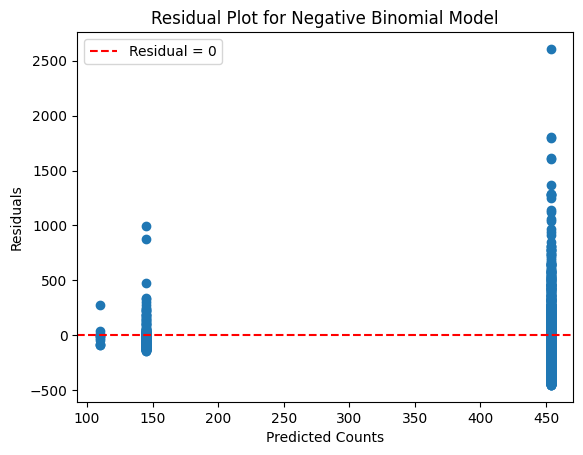

In [21]:
residuals = df['pos_total_beds'] - res.predict()

plt.scatter(res.predict(), residuals)
plt.xlabel('Predicted Counts')
plt.axhline(y=0, linestyle='--', color='red', label='Residual = 0')
plt.ylabel('Residuals')

plt.title('Residual Plot for Negative Binomial Model')
plt.legend()  # Show the legend
plt.show()



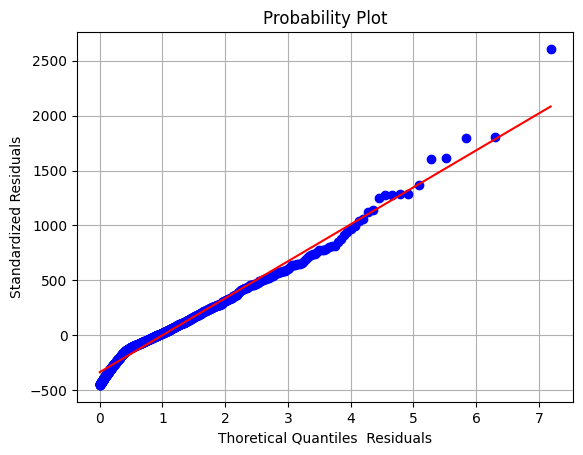

In [22]:
stats.probplot(residuals, dist="expon", plot=plt)
plt.ylabel(('Standardized Residuals'))
plt.xlabel(('Thoretical Quantiles  Residuals'))
plt.grid(True)  # Add grid lines for clarity
plt.show()

In [24]:
y = df['pos_total_beds']
X =df['currently_pe']



In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# train results
validation = res.predict(X_train)
rmserr = np.mean((y_train -validation)**2)
print(f'MSE for train results: {rmserr}')
print('rmse: ',sm.tools.eval_measures.rmse(y_train, validation, axis = 0))

MSE for train results: 109200.5903357668
rmse:  330.4551260546079


In [27]:
# test results
validation = res.predict(X_test)
mserr = np.mean((y_test -validation)**2)
print(f'MSE for test results: {mserr}')
print('rmse: ',sm.tools.eval_measures.rmse(y_test, validation, axis = 0))

MSE for test results: 131864.7114693172
rmse:  363.13181004879925


### Conclusion

In summary, hospitals owned by private equity (PE) firms have significantly fewer total beds compared to non-PE-owned hospitals. The hospital type (PE or non-PE) is closely tied to the total bed capacity. Specifically, PE-owned hospitals exhibit an 80% reduction in total beds compared to their non-PE counterparts. Consequently, patients in PE-owned hospitals may experience longer waiting periods for care due to the limited bed availability and potentially fewer healthcare staff.”

### Recommendation

Quality Focus: By linking investor profits to quality metrics, hospitals would prioritize patient care, safety, and outcomes. This shift from purely financial goals to quality-driven objectives benefits patients and the healthcare system.

Transparency: Clear quality standards and reporting requirements ensure transparency. Investors would be incentivized to actively monitor and improve hospital performance.